In [2]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import sys
import pyodbc
import time

import myfunctions as myf

dloc = '//teams.deutsche-boerse.de@SSL/DavWWWRoot/sites/sp0056/WFT Data/2667/05_BT/01_calc_steps/'

histloc = dloc + 'universe/01_gl1800.csv'

creds = 'DRIVER={SQL Server};SERVER=delacroix.prod.ci.dom;DATABASE=qai;UID=stx-txg2a;PWD=stx-txg2a'
con = pyodbc.connect(creds)


def get_tr_series(ic, startdate, enddate, currency):
    #startdate_ = startdate - dt.timedelta(days=15)
    #startdate = startdate_ - dt.timedelta(days=(startdate_.day)) + dt.timedelta(days=1)

    c = get_currency(ic, ic)
    if (c == currency) or (currency == 'loc'):
        sql = """
        SELECT MarketDate, RI
        FROM DS2PrimQtRI
        WHERE InfoCode = ?
            AND MarketDate <= ?
            AND MarketDate >= ?
        """
        df = pd.read_sql(sql, con, index_col='MarketDate', params=[str(ic), str(enddate), str(startdate)])
        df.columns = [ic]
    else:
        sql = """
        SELECT r.MarketDate, r.RI / fxr.MidRate
        FROM DS2PrimQtRI r, DS2FXCode fxc, DS2FXRate fxr
        WHERE fxc.FromCurrCode = ?
            AND fxc.ToCurrCode = ?
            AND fxc.RateTypeCode = 'SPOT'
            AND fxr.ExRateIntCode = fxc.ExRateIntCode
            AND fxr.ExRateDate = r.MarketDate
            AND r.InfoCode = ?
            AND r.MarketDate >= ?
            AND r.MarketDate <= ?
        """
        df = pd.read_sql(sql, con, index_col='MarketDate',
                         params=[str(c), str(currency), str(ic), str(startdate), str(enddate)])
        df.columns = [ic]
    if c == 'GBP':
        df = df / 100.
    df.index.name = None
    return df.sort_index()


def get_pr_series(ic, startdate, enddate, currency):
    startdate_ = startdate - dt.timedelta(days=15)
    startdate = startdate_ - dt.timedelta(days=(startdate_.day)) + dt.timedelta(days=1)

    c = get_currency(ic, ic)
    if (c == currency) or (currency == 'loc'):
        sql = """
        SELECT MarketDate, Close_
        FROM DS2PrimQtPrc
        WHERE InfoCode = ?
            AND MarketDate <= ?
            AND MarketDate >= ?
        """
        df = pd.read_sql(sql, con, index_col='MarketDate', params=[str(ic), str(enddate), str(startdate)])
        df.columns = [ic]
    else:
        sql = """
        SELECT r.MarketDate, r.Close_ / fxr.MidRate
        FROM DS2PrimQtPrc r, DS2FXCode fxc, DS2FXRate fxr
        WHERE fxc.FromCurrCode = ?
            AND fxc.ToCurrCode = ?
            AND fxc.RateTypeCode = 'SPOT'
            AND fxr.ExRateIntCode = fxc.ExRateIntCode
            AND fxr.ExRateDate = r.MarketDate
            AND r.InfoCode = ?
            AND r.MarketDate >= ?
            AND r.MarketDate <= ?
        """
        df = pd.read_sql(sql, con, index_col='MarketDate',
                         params=[str(c), str(currency), str(ic), str(startdate), str(enddate)])
        df.columns = [ic]
    if c == 'GBP':
        df = df / 100.
    df.index.name = None
    return df.sort_index()


def get_moend_tr_series(ic, startdate, enddate, currency):
    try:
        df1 = get_tr_series(ic, startdate, enddate, currency)
        dates = pd.DatetimeIndex(df1.index)
        ismonthend = (dates.day[0:len(dates) - 1] > dates.day[1:len(dates)])
        ismonthend = list(ismonthend)
        ismonthend.append(True)
        return df1[df1.index.isin(dates[ismonthend])]
    except:
        return np.nan


def get_moend_pr_series(ic, startdate, enddate, currency):
    try:
        df1 = get_pr_series(ic, startdate, enddate, currency)
        dates = pd.DatetimeIndex(df1.index)
        ismonthend = (dates.day[0:len(dates) - 1] > dates.day[1:len(dates)])
        ismonthend = list(ismonthend)
        ismonthend.append(True)
        return df1[df1.index.isin(dates[ismonthend])]
    except:
        return np.nan


def get_currency(identifier, infoc=0):
    try:
        if infoc == 0:
            ic = q.get_infocode(identifier)
        elif infoc != 0:
            ic = infoc

        if np.isnan(int(ic)):
            return np.nan
        else:
            sql = """
            SELECT PrimISOCurrCode
            FROM Ds2CtryQtInfo
            WHERE Infocode = ?
            """
            res = pd.read_sql(sql, con, params=[str(ic)]).values
            if len(res) > 0:
                return res[0][0]
            else:
                return np.nan
    except:
        return np.nan


def get_fxrate(fromcurr, tocurr, date):
    """Return exchange rate
    Most recent if not available on date

    Keyword arguements:
    date -- (datetime.date)
    fromcurr -- (string)
    tocurr -- (string)
    """
    if fromcurr == tocurr:
        return 1
    else:
        sqlcode = """
        SELECT ExRateIntCode
        FROM DS2FXCode
        WHERE FromCurrCode = '%s'
            AND ToCurrCode = '%s'
            AND RateTypeCode = 'SPOT'
        """ % (fromcurr, tocurr)
        try:
            exrateintcode = pd.io.sql.read_sql(sqlcode, con).loc[0, 'ExRateIntCode']
        except:
            return np.nan
        sqlrate = """
        SELECT MidRate
        FROM DS2FxRate
        WHERE ExRateIntCode = '%s'
            AND ExRateDate <= '%s'
            ORDER BY ExRateDate DESC
        """ % (str(exrateintcode), dt.date.strftime(date, '%Y-%m-%d'))
        try:
            return pd.io.sql.read_sql(sqlrate, con).loc[0, 'MidRate']
        except:
            return np.nan


In [ ]:
#create some selection and pull prices

from pandas.tseries.offsets import BDay

dfin = pd.read_csv(dloc + '04_Deka_Europe_Multi_Factor_weights_capped.csv', sep=';', dtype={'sedol': str})

dfin['Date'] = pd.to_datetime(dfin['Date'], format='%Y-%m-%d', dayfirst=True)
dfin['cutoff'] = pd.to_datetime(dfin['cutoff'], format='%Y-%m-%d', dayfirst=True)

dfin['infocode'] = dfin['infocode'].fillna(0)
dfin['infocode'] = dfin['infocode'].map(lambda x: int(x))

dfin = dfin.sort_values(['Date', 'ffmcap'])

#do a simple ranking to select
rk = dfin.groupby('Date')['ffmcap'].rank(method='first', ascending=1, pct=False)
dfin['rk'] = rk

dfin = dfin[dfin.rk<=150].copy()
#dfin.groupby('Date').count()['isin'].plot()

dfin = dfin.reset_index(drop=True)
#dfin = dfin[dfin.Date==dt.date(2017,9,18)][['Date','isin','name','country','sec_curr','ICB_ind','ICB_ind_name','infocode']].copy()
dfin = dfin[['Date','isin','name','country','sec_curr','ICB_ind','ICB_ind_name','infocode']].copy()


for d in dfin.Date.drop_duplicates():
    print(d)
    dfd = dfin[dfin.Date == d].reset_index(drop=True)
    d1 = d - dt.timedelta(d.day-1)
    d1 = d + dt.timedelta(days=1)
    dto = d - dt.timedelta(d.day)
    dfrom = myf.add_months(dto + dt.timedelta(1), -36) - BDay(1)

    #dftr = pd.DataFrame()
    #for ic in dfd.infocode:
    #    print(ic, dto,dfrom)
    #    dftemp = dkf.get_tr_series(ic, dfrom, dto, 'loc')
    #    isin_ = dfd[dfd.infocode == ic].reset_index(drop=True).loc[0,'isin']
    #    dftemp.columns = [isin_]
    #    dftr = pd.concat([dftr, dftemp], axis=1)

    dfd.to_csv(dkf.dloc + 'minvar/components/components_' + str(d)[:10] + '.csv', sep=';', index=False)
    #dftr.to_csv(dkf.dloc + 'minvar/prices/prices_tr_' + str(d)[:10] + '.csv' ,sep=';',index=False)

print("done")

In [200]:
#min var
from scipy.optimize import minimize

def port_var(w):
    return np.dot(w,np.dot(covs,w))

ind_max=0.2
co_max=0.2
w_max=0.08

dfd = pd.read_csv(dloc + '03_Deka_Europe_Multi_Factor_adtv_v2.csv', sep=';')
dfd['Date'] = pd.to_datetime(dfd['Date'], format='%d.%m.%Y', dayfirst=True)

dfd = dfd[-1:].copy()

for d in dfd['Date'].drop_duplicates():

    dx = str(d)[:10]
    print(dx)

    dfcomp = pd.read_csv(dloc + 'minvar/components/components_' + dx + '.csv', sep=';')

    dfpr = pd.read_csv(dloc + 'minvar/prices/prices_tr_'+ dx + '.csv', sep=';')
    dfpr.fillna(method='pad', inplace=True)
    dfpr.fillna(method='bfill', inplace=True)
    
    returns = np.array(dfpr.iloc[1:len(dfpr), 1:]) / np.array(dfpr.iloc[0:len(dfpr) - 1, 1:])
    logreturns = [np.log((returns.T)[i]) for i in range(len(returns.T))]
    covs = np.cov(logreturns)*252

    n=len(covs)
    b_ = [(0., w_max) for i in range(n)]
    
    cons = np.array([])
    cons = np.append(cons, {'type': 'eq', 'fun': lambda w: sum(w) - 1.})
    
    #industry constraints
    #https://stackoverflow.com/questions/45491376/scipy-optimization-not-running-when-i-try-to-set-constraints-using-a-for-loop/45493887#45493887
    industryidx=list()
    for i in np.unique(list(dfcomp.ICB_ind)):
        industryidx.append(dfcomp[dfcomp.ICB_ind==i]['isin'].index)
    
    for ind in range(len(industryidx)):
        con ={'type':'ineq', 'fun': lambda w, ind=ind: sum(w[industryidx[ind]])-ind_max}
        cons = np.append(cons, con)
    
    #country constraint
    countryidx=list()
    for co in np.unique(list(dfcomp.country)):
        countryidx.append(dfcomp[dfcomp.country==co]['isin'].index)
    
    for cntry in range(len(countryidx)):
        con ={'type':'ineq', 'fun': lambda w, cntry=cntry: sum(w[countryidx[cntry]])-co_max}
        cons = np.append(cons, con)

    w0 = np.ones(n) / n

    optiwgts = minimize(port_var, w0, method='SLSQP', bounds=b_, constraints=cons)
    
    dfcomp['weight'] = optiwgts.x
    dfcomp.loc[dfcomp[dfcomp.weight<1e-05].index, 'weight'] = 0
    
    print('pf var - opti weight:', np.dot(optiwgts.x, np.dot(covs,optiwgts.x)))
    print('pf var - equal weight:', np.dot(w0, np.dot(covs,w0)))

#pd.DataFrame(returns).to_csv(dloc + 'minvar/returns.csv',sep=';')
print('done')

2017-09-18
done


In [201]:
dfcomp.groupby('ICB_ind_name').sum()['weight'].sort_values(ascending=False)

ICB_ind_name
Financials            0.200000
Industrials           0.193711
Consumer Services     0.174843
Health Care           0.086792
Consumer Goods        0.080503
Basic Materials       0.074214
Oil & Gas             0.055346
Technology            0.049057
Utilities             0.042767
Telecommunications    0.042767
Name: weight, dtype: float64

In [202]:
dfcomp.groupby('country').sum()['weight'].sort_values(ascending=False)

country
GB    0.200000
DE    0.118239
FR    0.118239
SE    0.099371
CH    0.074214
IT    0.067925
NL    0.055346
DK    0.049057
ES    0.049057
BE    0.042767
NO    0.036478
FI    0.023899
AT    0.023899
CZ    0.023899
LU    0.017610
Name: weight, dtype: float64

In [203]:
dfcomp.loc[dfcomp[dfcomp.weight!=0].index, 'weight'].sort_values(ascending=False)

118    0.080000
92     0.057725
115    0.055346
77     0.055346
70     0.049057
139    0.048634
52     0.042767
90     0.041460
46     0.039078
131    0.038239
107    0.036478
134    0.035568
127    0.033248
12     0.030215
82     0.028988
15     0.028164
128    0.025157
48     0.023914
96     0.023899
137    0.023899
120    0.023899
44     0.021874
138    0.020893
37     0.019508
72     0.017610
102    0.016625
27     0.016611
95     0.016604
125    0.011815
93     0.010818
144    0.006835
116    0.005186
64     0.003690
88     0.002986
50     0.002939
87     0.001629
41     0.001596
34     0.000999
145    0.000702
Name: weight, dtype: float64

In [209]:
dfcomp.loc[dfcomp[dfcomp.weight>0.045].index, 'weight'].sum()

0.3461071265718125

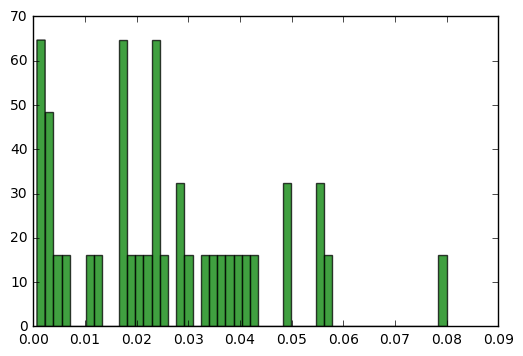

In [204]:
import matplotlib.pyplot as plt
# the histogram of the data
fin_decent_wgts = list(dfcomp.loc[dfcomp[dfcomp.weight!=0].index, 'weight'])
n, bins, patches = plt.hist(fin_decent_wgts, 50, normed=1, facecolor='g', alpha=0.75)
plt.show()

In [52]:
#contraints without minvar

from scipy.optimize import minimize

def port_dummy(w):
    return 1

ind_max=0.2
co_max=0.2
w_max=0.09

dfd = pd.read_csv(dloc + '04_Deka_Europe_Multi_Factor_weights_capped.csv', sep=';')
dfd['Date'] = pd.to_datetime(dfd['Date'], format='%Y-%m-%d', dayfirst=True)

#dfd = dfd[dfd.Date=='2004-03-22'].copy()

for d in dfd['Date'].drop_duplicates():

    dx = str(d)[:10]
    print(dx)

    dfcomp = dfd[(dfd.Date==d) & -(dfd.weight.isnull())]
    
    n = len(dfcomp)
    b_ = [(0., w_max) for i in range(n)]
    
    cons = np.array([])
    cons = np.append(cons, {'type': 'eq', 'fun': lambda w: sum(w) - 1.})
    
    #industry constraints
    #https://stackoverflow.com/questions/45491376/scipy-optimization-not-running-when-i-try-to-set-constraints-using-a-for-loop/45493887#45493887
    industryidx=list()
    for i in np.unique(list(dfcomp.ICB_ind)):
        industryidx.append(dfcomp[dfcomp.ICB_ind==i]['isin'].index)
    
    for ind in range(len(industryidx)):
        con ={'type':'ineq', 'fun': lambda w, ind=ind: sum(w[industryidx[ind]])-ind_max}
        cons = np.append(cons, con)
    
    #country constraint
    countryidx=list()
    for co in np.unique(list(dfcomp.country)):
        countryidx.append(dfcomp[dfcomp.country==co]['isin'].index)
    
    for cntry in range(len(countryidx)):
        con ={'type':'ineq', 'fun': lambda w, cntry=cntry: sum(w[countryidx[cntry]])-co_max}
        cons = np.append(cons, con)

    #w0 = np.ones(n) / n
    w0 = np.array(dfcomp['weight'])
    
    optiwgts = minimize(port_dummy, w0, method='SLSQP', bounds=b_, constraints=cons)
    
    dfcomp['weight_optimised'] = optiwgts.x
    

#pd.DataFrame(returns).to_csv(dloc + 'minvar/returns.csv',sep=';')
print('done')

2004-03-22
2004-06-21


C:\Users\iv822\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


IndexError: index 431 is out of bounds for axis 1 with size 50

In [55]:
w0

array([ 0.04555187,  0.04417701,  0.04342535,  0.03604401,  0.0357696 ,
        0.0337947 ,  0.03330377,  0.03088201,  0.03055279,  0.02748119,
        0.02729471,  0.02670535,  0.02586832,  0.02428886,  0.02262121,
        0.02097435,  0.02092941,  0.0201605 ,  0.01992575,  0.01980652,
        0.01965915,  0.01938947,  0.01904182,  0.01798282,  0.01784621,
        0.01714251,  0.01708038,  0.01642523,  0.01563161,  0.01516759,
        0.0150602 ,  0.01471466,  0.01456803,  0.01387084,  0.01379278,
        0.01377138,  0.01369307,  0.01318649,  0.01294381,  0.01292043,
        0.01214693,  0.01149746,  0.01017082,  0.00983622,  0.00972269,
        0.00926262,  0.00920746,  0.0084741 ,  0.0082594 ,  0.00797653])

In [42]:
optiwgts.x

array([ 0.05369207,  0.03519581,  0.02924817,  0.03711932,  0.03036789,
        0.03012504,  0.03180763,  0.02991224,  0.02898952,  0.02845666,
        0.02678522,  0.02323762,  0.02682057,  0.02707464,  0.02508096,
        0.02312627,  0.02558789,  0.02575139,  0.02086904,  0.02214267,
        0.0183745 ,  0.01580131,  0.01984332,  0.01755104,  0.02008496,
        0.01451847,  0.01902986,  0.01904704,  0.01706343,  0.01765848,
        0.01698136,  0.01346573,  0.01656187,  0.01410867,  0.0164613 ,
        0.01622652,  0.01364815,  0.0134276 ,  0.01307026,  0.01153519,
        0.00921611,  0.01279276,  0.00844995,  0.00721784,  0.01084075,
        0.01033022,  0.00975968,  0.00745128,  0.00829785,  0.00979385])

In [44]:
dfcomp.groupby('ICB_ind_name').sum()['weight'].sort_values(ascending=False)

ICB_ind_name
Technology            0.213468
Financials            0.175085
Industrials           0.154586
Consumer Services     0.148805
Basic Materials       0.121103
Consumer Goods        0.092202
Utilities             0.052627
Telecommunications    0.028991
Health Care           0.013133
Name: weight, dtype: float64

In [45]:
dfcomp.groupby('ICB_ind_name').sum()['weight_optimised'].sort_values(ascending=False)

ICB_ind_name
Technology            0.200000
Financials            0.175497
Industrials           0.155338
Consumer Services     0.149653
Basic Materials       0.122410
Consumer Goods        0.093986
Utilities             0.055067
Telecommunications    0.031823
Health Care           0.016227
Name: weight_optimised, dtype: float64

In [46]:
dfcomp.groupby('country').sum()['weight'].sort_values(ascending=False)

country
DE    0.261225
FR    0.187235
NL    0.122956
FI    0.065752
IT    0.057031
CH    0.055619
GB    0.054515
DK    0.043255
SE    0.041957
NO    0.034668
GR    0.034377
ES    0.028037
BE    0.013371
Name: weight, dtype: float64

In [51]:
dfcomp.groupby('country').sum()['weight_optimised'].sort_values(ascending=False)

country
DE    0.233721
FR    0.187447
NL    0.124232
FI    0.067975
IT    0.059398
CH    0.058009
GB    0.056923
DK    0.045850
SE    0.044574
NO    0.037405
GR    0.037119
ES    0.030884
BE    0.016461
Name: weight_optimised, dtype: float64